# The rotating cone problem

Over a unit square a blob of heat is rotated one revolution subject to a Péclet number of 1e6.  
The evolution of the heat is governed by the advection diffusion equation.  

In Underworld this equation can be numerically approximated with 2 methods: the Streamline Upwind/Petrov-Galerkin method (**SUPG**); and the Semi-Lagrangian Crank-Nicholson methd (**SLCN**). Various numerical parameters can be investigate in the model below.

This classical test problem is taken from J. Donea and A. Huerta, _Finite Element Methods for Flow Problems (2003)_ with an initial field (temperature in this case) given:

    
$$
T(x,y,0) = 
\begin{array}{cc}
  \biggl\{ & 
    \begin{array}{cc}
      \frac{1}{4}(1+\cos(\pi X))(1+\cos(\pi Y)) & X^2 + Y^2 \leq 1, \\
      0 & X^2 + Y^2 \gt 1, \\
    \end{array}
\end{array}
$$

where $$
(X, Y) = (\space (x-x_0) / \sigma ,\space (y-y_0) / \sigma)\space)
$$ 

with $(x_0, y_0)$ as the center of the blob and the boundary condition is $T=0$ on all walls.

The domain is a unit square $[-0.5,0.5]x[-0.5,0.5]$. The advection field is of pure rotation with velocity as $V(x,y) = (-y,x)$. A static timestep $dt = \frac{2\pi}{200} $.


In [1]:
import underworld as uw
import underworld.function as fn
import underworld.visualisation as vis
import numpy as np

In [2]:
# numerical parameters
nEls  = 30           # number of elements in x & y
dt    = 2*np.pi/200  # timestep size
viz   = (1 if uw.mpi.size==1 else 0)

In [3]:
def runModel(method, nEls = nEls, dt = dt, elementType='Q1', viz = 1, rotations = 1., diffuseOnly=False):
    """
    Defines and executes "rotating cone problem" numerical model.
    
    Args
    ----
    method : str, "SUPG" or "SLCN"
        The numerical scheme used to evolve the temperature in time.
    
    nEls : int
        The number of elements of that define the numerical domain, 
        equal in both axis.
    
    dt : float
        The dimensionless timestep size used to integrate the temperature 
        field one time step.
    
    Q1 : str
        The underworld finite element type used to approximate the temperature field 
        
    viz : bool
        Show the initial and final timesteps of the model
    
    rotations: float
        Number of rotations to perform.
    
    diffuseOnly : bool
        Don't advect the model (zero velocity field). Only diffuse process allowed.
        
    Returns
    -------
    maxT : float
        The maximum temperature after one revolution.
    
    avgT : float
        The average temperature after one revolution.
    
    num_t : float
        Wall time (fractional seconds) taken to complete.
    
    steps : int
        The number of discrete time steps to taken to complete.
    """
    
    # default model parameters
    sigma = 0.2          # width of blob
    x_0   = (1./6, 1./6) # position of blob
    kappa = 1e-6         # thermal diffusion (entire domain)
    # unit 2D mesh max/min coords
    minCoord = [-0.5,-0.5]
    maxCoord = [0.5,0.5]
              
    # build FE mesh, velocity and temperature fields
    mesh = uw.mesh.FeMesh_Cartesian(elementType = elementType, 
                                    elementRes  = (nEls,nEls),
                                    minCoord    = minCoord,
                                    maxCoord    = maxCoord )

    tField = mesh.add_variable(1)
    vField = mesh.add_variable(2)

    all_walls = mesh.specialSets["AllWalls_VertexSet"]
    
    # initialise fields
    x_vel = -1.*uw.function.coord()[1]
    y_vel =  1.*uw.function.coord()[0]
    vField.data[:,0] = x_vel.evaluate(mesh).reshape(-1)
    vField.data[:,1] = y_vel.evaluate(mesh).reshape(-1)
    
    if diffuseOnly:
        vField.data[...] = 0.

    fn_X = (fn.input()[0]-x_0[0])/sigma
    fn_Y = (fn.input()[1]-x_0[1])/sigma
    
    fn_inside = ( fn.math.pow(fn_X,2.) + fn.math.pow(fn_Y,2.) ) <= 1.
    fn_hill   = 0.25 * ( 1.+fn.math.cos(np.pi*fn_X) ) * ( 1.+fn.math.cos(np.pi*fn_Y) )

    fn_ic = fn.branching.conditional([(fn_inside, fn_hill ), 
                                      (True     , 0.)])
    
    tField.data[:] = fn_ic.evaluate(mesh)

    # setup visualisation
    fig = vis.Figure()
    fig.VectorArrows(mesh,vField)
#     fig.Mesh(mesh)
    fig.Surface(mesh,tField, valueRange=[0.,1.]);
 
    # define advection diffusion system
    dbc = uw.conditions.DirichletCondition(variable=tField,
                                           indexSetsPerDof=all_walls)

    # extra variable needed with supg
    tDotField = None
    if method == "SUPG":
        tDotField = mesh.add_variable( nodeDofCount=1, dataType='double')
        
    system = uw.systems.AdvectionDiffusion( phiField       = tField,
                                            method         = method,
                                            phiDotField    = tDotField,
                                            velocityField  = vField,
                                            fn_diffusivity = kappa,
                                            conditions     = [dbc], kwargs=None )
      
    from timeit import default_timer as timer

    t0    = timer()
    num_t = 0
    time  = 0
    steps = 0
    end_t = 2.*np.pi*rotations

    if dt < 0:
        dt = system.get_max_dt()
        
    # time loop
    while (time+dt)<end_t:

        system.integrate(dt)

        time  += dt
        steps += 1
        ### uncomment below for all .png images saved to disk
        # fig.save_image("{}-{}".format(method, str(steps).zfill(4)))

    num_t = timer()-t0
    
    if viz: fig.show()
    
    # metrics for temperature evolution
    measureT = fn.view.min_max(tField,fn_auxiliary=fn.input())
    measureT.reset()
    measureT.evaluate(mesh);
    maxT = measureT.max_global()

    intT,vol = mesh.integrate(fn=(tField,1.))
    avgT     = intT/vol
    
    if uw.mpi.rank == 0:
        if diffuseOnly: method += " (diffusion only)"
        print("{}: t_max={:.15f}, t_avg={:.15f}, wall time={:.4e}, its={}, dt={:.4e}".format(
            method, maxT, avgT, num_t, steps, dt))
          
    return maxT, avgT, num_t, steps, nEls, dt


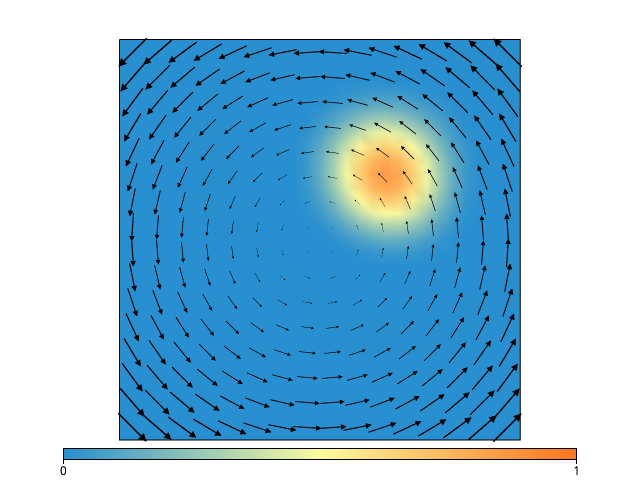

SLCN: t_max=0.852184812161144, t_avg=0.040071167501391, wall time=4.3059e+00, its=200, dt=3.1416e-02



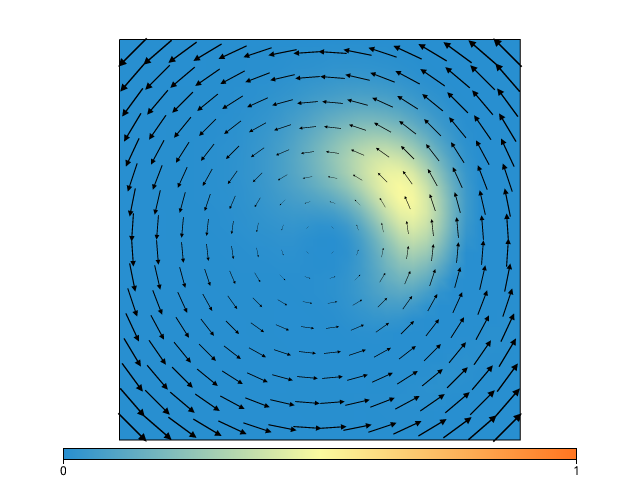

SUPG: t_max=0.494862381241538, t_avg=0.039927886622725, wall time=2.0663e+00, its=200, dt=3.1416e-02


In [4]:
# uncomment the following 2 line to test no rotation scenarios: 
#  1. the initial condition
#  2. heat diffusion only
#results_slcn = runModel("SLCN", nEls = nEls, dt = dt, viz = viz, rotations=0.)     # initial conditions only
#results_slcn = runModel("SLCN", nEls = nEls, dt = dt, viz = viz, diffuseOnly=True) # diffuse only
results_slcn = runModel("SLCN", nEls = nEls, dt = dt, viz = viz)
results_supg = runModel("SUPG", nEls = nEls, dt = dt, viz = viz)

In [5]:
# test the max temperature and avg. temperature iff nEls == 30
# against expected results for 1 proc
if uw.mpi.size == 0:
    if [results_supg[3],results_supg[4]] == [200,30]:
        expected = [0.494862, 0.039927]
        if not np.allclose([results_supg[0],results_supg[1]], 
                            expected, rtol=1e-2):
            raise RuntimeError("Failed SUPG test")
    
    if [results_slcn[3],results_slcn[4]] == [200,30]:
        expected = [0.852184,0.040071]
        if not np.allclose([results_slcn[0], results_slcn[1]],
                            expected, rtol=1e-2):
            raise RuntimeError("Failed SLCN test")        